
Training data shape: X_train: (1848, 13), y_train: (1848,)
Testing data shape: X_test: (462, 13), y_test: (462,)

--- Tuning RandomForest Regressor ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Hyperparameters for RandomForest:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.75, 'max_depth': 10, 'bootstrap': True}

Tuned RandomForest Evaluation Metrics:
  MAE: 1.6063
  MSE: 6.4402
  RMSE: 2.5378
  R²: 0.9047

--- Comparison Summary ---
Default RandomForest MAE: 1.6529, R²: 0.8989
Tuned RandomForest   MAE: 1.6063, R²: 0.9047


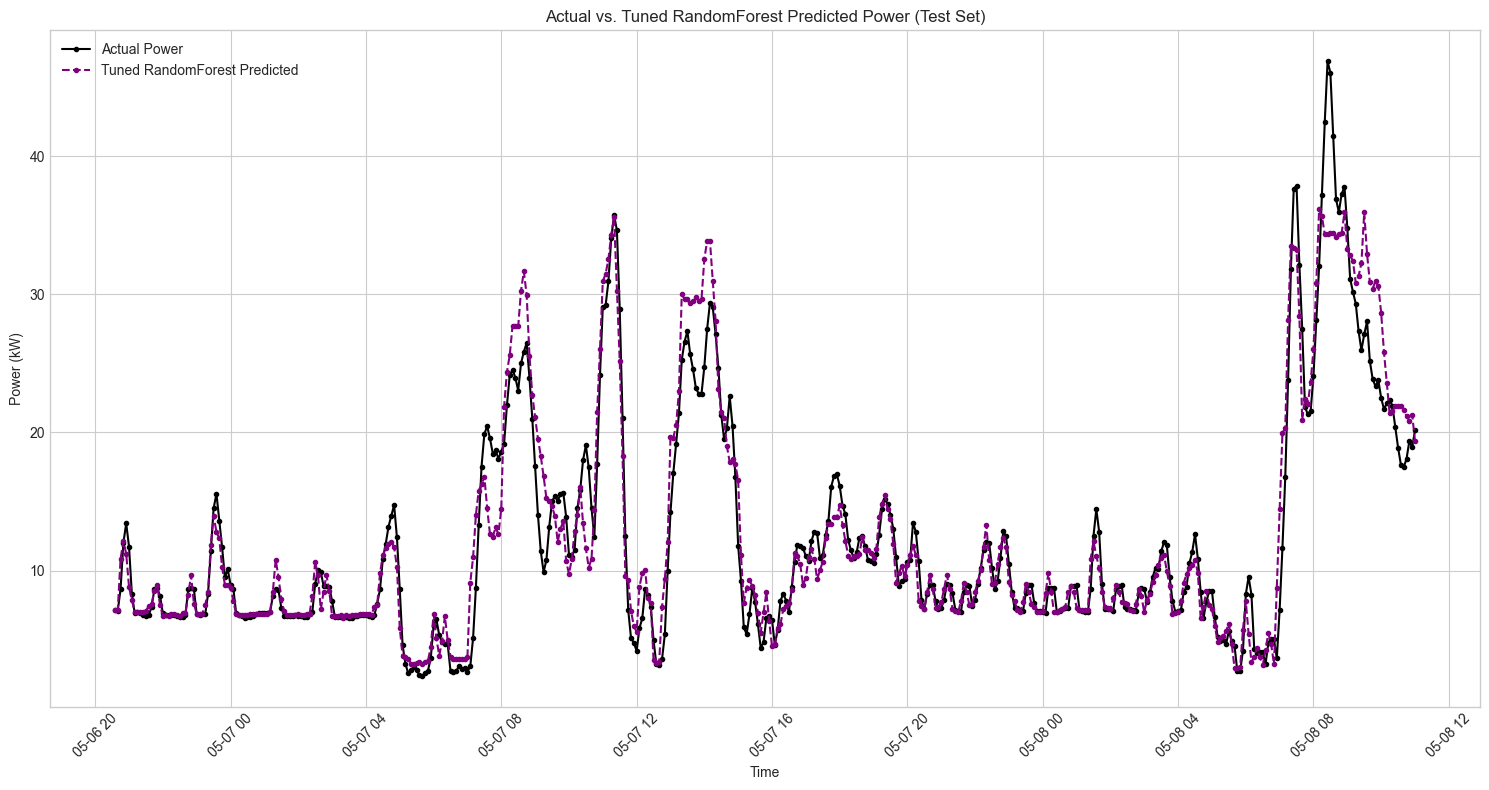


Top 5 Feature Importances for Tuned RandomForest:
          feature  importance
2   AIrmsAvg_Amps    0.713886
3   BIrmsAvg_Amps    0.166840
4   CIrmsAvg_Amps    0.065032
7            hour    0.011994
1  BVrmsAvg_Volts    0.011051


C:\Users\hp\AppData\Local\Temp\ipykernel_10500\4280400782.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importances_tuned_rf.head(10), palette='mako')


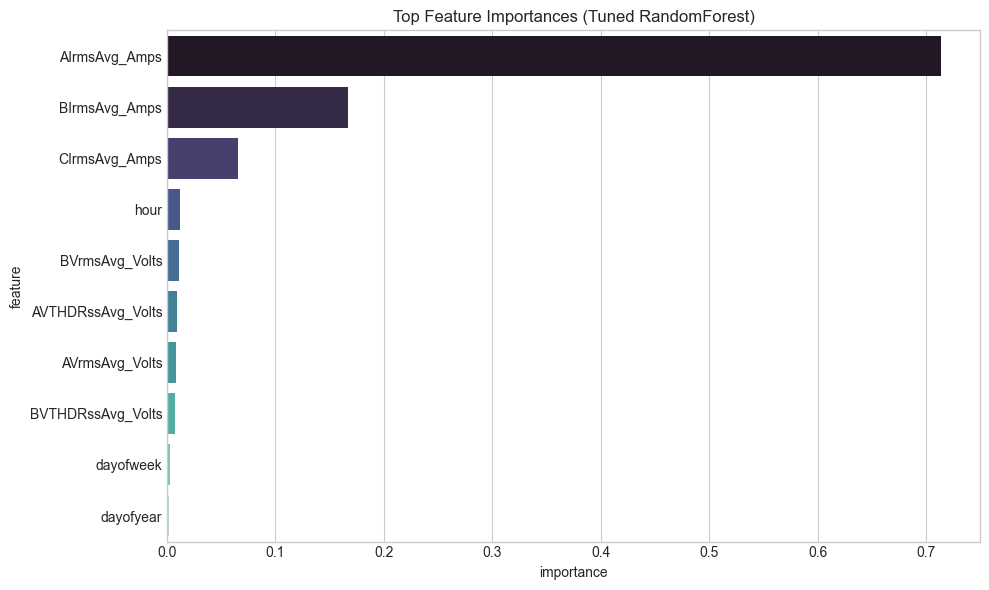


--- RF Tuning pipeline execution complete ---


In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split # TimeSeriesSplit for more robust CV later
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

def run_rf_tuning_pipeline():
    # --- Load and Prepare Data (Same as before) ---
    file_path = r"C:\Users\hp\Desktop\REG108S\Project\MeasuredData_Filled.csv" # Ensure this file is accessible

    df = pd.read_csv(file_path)
    
    df['X-Data'] = pd.to_datetime(df['X-Data'])
    df.set_index('X-Data', inplace=True)
    original_columns = df.columns.tolist()
    new_columns = [col.replace('[', '_').replace(']', '').replace('(', '_').replace(')', '').replace('/', '_') for col in original_columns]
    df.columns = new_columns

    columns_to_drop = ['CVrmsAvg_Volts', 'CVTHDRssAvg_Volts']
    existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
    if existing_columns_to_drop:
        df.drop(columns=existing_columns_to_drop, inplace=True)

    anomalous_rows_mask = (df['AVrmsAvg_Volts'] < 100)
    df_cleaned = df[~anomalous_rows_mask].copy()

    if df_cleaned.empty:
        print("Error: DataFrame is empty after removing anomalous rows. Cannot proceed.")
        return

    df_cleaned['hour'] = df_cleaned.index.hour
    df_cleaned['dayofweek'] = df_cleaned.index.dayofweek
    df_cleaned['dayofyear'] = df_cleaned.index.dayofyear
    df_cleaned['month'] = df_cleaned.index.month
    df_cleaned['quarter'] = df_cleaned.index.quarter
    df_cleaned['weekofyear'] = df_cleaned.index.isocalendar().week.astype(int)
    
    target_variable = 'TOTDemand_kWh_hValue_kWh_h'
    if target_variable not in df_cleaned.columns:
        print(f"Error: Target variable '{target_variable}' not found.")
        return

    X = df_cleaned.drop(columns=[target_variable])
    y = -1 * df_cleaned[target_variable]

    test_size = 0.2
    # For time series, it's better not to shuffle. train_test_split shuffles by default.
    # We'll do a manual chronological split.
    if len(X) < 10:
        print("Warning: Not enough data for a robust train/test split. Results may not be reliable.")
        X_train, X_test = X, X
        y_train, y_test = y, y
    else:
        split_index = int(len(X) * (1 - test_size))
        X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
        y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    if X_train.empty or X_test.empty:
        print("Error: Training or testing set is empty after split.")
        return

    print(f"\nTraining data shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Testing data shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

    # --- Hyperparameter Tuning for RandomForest ---
    print("\n--- Tuning RandomForest Regressor ---")
    param_dist_rf = {
        'n_estimators': [100, 200, 300, 500],
        'max_features': ['sqrt', 'log2', 0.5, 0.75, 1.0], # Changed 'auto' to 1.0 (all features) or 'sqrt'/'log2'
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 4, 6],
        'bootstrap': [True] # Typically True for RF
    }

    # Note: For time-series data, standard k-fold CV in RandomizedSearchCV shuffles data, which is not ideal.
    # A TimeSeriesSplit cross-validator would be better for robust tuning.
    # For simplicity here, we'll use default CV, but be mindful of this for final model selection.
    # cv=3 is a small number of folds, increase if computation time allows (e.g., 5)
    # n_iter is the number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
    rf_random_search = RandomizedSearchCV(
        RandomForestRegressor(random_state=42),
        param_distributions=param_dist_rf,
        n_iter=20,  # Number of parameter combinations to try (can be increased)
        cv=3,       # Number of cross-validation folds (consider TimeSeriesSplit for actual projects)
        scoring='neg_mean_squared_error', # We want to minimize MSE (maximize neg_MSE)
        random_state=42,
        n_jobs=-1,  # Use all available cores
        verbose=1   # Set to 0 for less output, 1 or 2 for more
    )
    
    rf_random_search.fit(X_train, y_train)
    
    print("\nBest Hyperparameters for RandomForest:")
    print(rf_random_search.best_params_)
    
    best_rf_model = rf_random_search.best_estimator_
    
    # --- Evaluate Tuned RandomForest ---
    y_pred_tuned_rf = best_rf_model.predict(X_test)
    
    mae_tuned_rf = mean_absolute_error(y_test, y_pred_tuned_rf)
    mse_tuned_rf = mean_squared_error(y_test, y_pred_tuned_rf)
    rmse_tuned_rf = np.sqrt(mse_tuned_rf)
    r2_tuned_rf = -1.0
    if len(y_test) >=2:
        r2_tuned_rf = r2_score(y_test, y_pred_tuned_rf)

    print("\nTuned RandomForest Evaluation Metrics:")
    print(f"  MAE: {mae_tuned_rf:.4f}")
    print(f"  MSE: {mse_tuned_rf:.4f}")
    print(f"  RMSE: {rmse_tuned_rf:.4f}")
    print(f"  R²: {r2_tuned_rf:.4f}")

    # --- Comparison with Default Models (conceptual, assuming they were run before) ---
    # For a direct comparison, you would re-run default models here or store their metrics.
    # Let's fetch default RF metrics again for a clean comparison in this run.
    default_rf = RandomForestRegressor(random_state=42, n_estimators=100)
    default_rf.fit(X_train, y_train)
    y_pred_default_rf = default_rf.predict(X_test)
    mae_default_rf = mean_absolute_error(y_test, y_pred_default_rf)
    r2_default_rf = -1.0
    if len(y_test) >=2:
        r2_default_rf = r2_score(y_test, y_pred_default_rf)

    print("\n--- Comparison Summary ---")
    print(f"Default RandomForest MAE: {mae_default_rf:.4f}, R²: {r2_default_rf:.4f}")
    print(f"Tuned RandomForest   MAE: {mae_tuned_rf:.4f}, R²: {r2_tuned_rf:.4f}")
    
    # --- Visualization of Tuned RandomForest ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(15, 8))
    plt.plot(y_test.index, y_test, label='Actual Power', marker='.', linestyle='-', color='black')
    plt.plot(y_test.index, y_pred_tuned_rf, label='Tuned RandomForest Predicted', marker='.', linestyle='--', color='purple')
    plt.title('Actual vs. Tuned RandomForest Predicted Power (Test Set)')
    plt.xlabel('Time')
    plt.ylabel('Power (kW)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    if hasattr(best_rf_model, 'feature_importances_'):
        feature_importances_tuned_rf = pd.DataFrame({
            'feature': X_train.columns, 
            'importance': best_rf_model.feature_importances_
        })
        feature_importances_tuned_rf = feature_importances_tuned_rf.sort_values(by='importance', ascending=False)
        print("\nTop 5 Feature Importances for Tuned RandomForest:")
        print(feature_importances_tuned_rf.head(5))

        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=feature_importances_tuned_rf.head(10), palette='mako')
        plt.title('Top Feature Importances (Tuned RandomForest)')
        plt.tight_layout()
        plt.show()
        
    return df_cleaned, best_rf_model

if __name__ == '__main__':
    df_processed, tuned_rf_model = run_rf_tuning_pipeline()
    
    if df_processed is not None:
        print("\n--- RF Tuning pipeline execution complete ---")